In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import sys
import time
import os
import random

from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
print(now_str())


[05/12 15:55:16]


In [2]:
def load_images(img_dir, img_names):
    image_refs_out = {}
    crops_out = {}
    
    w = 2160 / 2
    for img_name in img_names:
        path = img_dir + '/{}/images/undistorted'.format(img_name)
        img_paths = sorted(glob.glob(path + '/*.jpg'))
        image_refs_undistort = []
        for i, path in enumerate(img_paths):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
            image_refs_undistort.append(img)

        image_refs_cropped = []
        for i in range(len(image_refs_undistort)):
            image = image_refs_undistort[i]
            cx = image.shape[1] / 2

            image = image_refs_undistort[i]
            img = image[:, int(cx-w):int(cx+w)]
            img = cv2.resize(img, (image_size, image_size))
            image_refs_cropped.append(img)
        image_refs_out[img_name] = image_refs_undistort
        crops_out[img_name] = image_refs_cropped
    return image_refs_out, crops_out
def load_clean_plates(img_dir):
    img_paths = sorted(glob.glob(img_dir + '/*.PNG'))
    images0 = []
    images_undistort = []
    for i, path in enumerate(img_paths):
        # img = imageio.imread(path)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        images0.append(img)
        images_undistort.append(img)

    w = 2160 / 2
    clean_plates_cropped = []
    for i in range(len(images_undistort)):
        image = images_undistort[i]
        cx = image.shape[1] / 2

        image = images_undistort[i].astype(np.float32)
        img = image[:, int(cx-w):int(cx+w)]
        img = cv2.resize(img, (image_size, image_size))
        # img = np.dstack([img, img, img])
        clean_plates_cropped.append(img)
    
    return images0, images_undistort, clean_plates_cropped 

In [5]:
clean_plate_dir = r'D:\Pictures\2019_12_13_Lada_Capture\CleanPlates\undistorted'
img_dir = './9_data/input'
img_names = ['04917']
# img_names = ['03052']
image_size = 1080

img_refs_undistorted: dict_keys(['04917'])
  (2160, 4000)
img_refs: dict_keys(['04917'])
  (1080, 1080)
clean_plates_original: (2160, 4000)


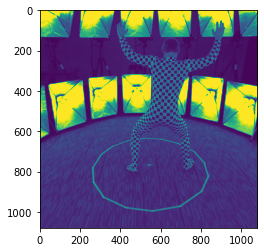

In [49]:
img_refs_undistorted, img_refs = load_images(img_dir, img_names)
print('img_refs_undistorted:', img_refs_undistorted.keys())
print('  {}'.format(img_refs_undistorted[list(img_refs_undistorted.keys())[0]][0].shape))
print('img_refs:', img_refs.keys())
print('  {}'.format(img_refs[list(img_refs.keys())[0]][0].shape))

clean_plates_original, clean_plates_undistort, clean_plates = load_clean_plates(clean_plate_dir)
print('clean_plates_original:', clean_plates_original[0].shape)

for k, v in img_refs.items():
    plt.figure()
    plt.imshow(v[0])
    plt.show()

In [50]:
def render_row(imgs):
    n_imgs = len(imgs)
    fig, ax = plt.subplots(1, n_imgs, figsize=(10*n_imgs, 10))
    if n_imgs == 1:
        ax = [ax]
    for i in range(n_imgs):
        img = imgs[i]
        ax[i].imshow(img, cmap='gray')
        ax[i].set_title('{} | {} | ({:.0f}, {:.0f})'.format(img.shape, img.dtype, np.min(img), np.max(img)))
        
    plt.show()

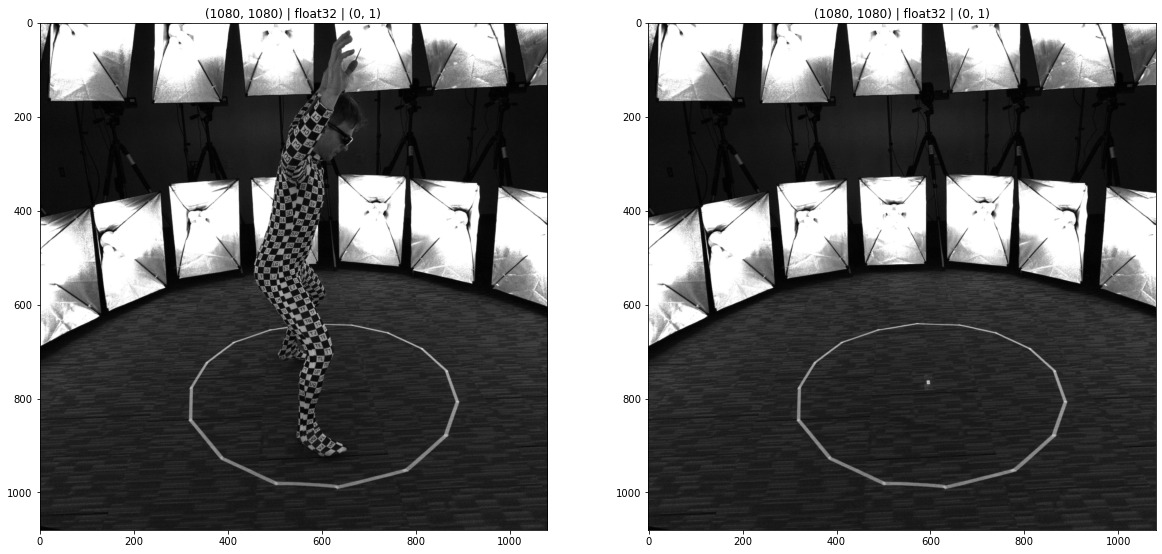

In [51]:
img_name = '04917'
cam_idx = 4
render_row([img_refs[img_name][cam_idx], clean_plates[cam_idx]])


In [39]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged
def DoG(img, kernel_size1, kernel_size2):
    b1 = cv2.GaussianBlur(img,(kernel_size1, kernel_size1),0)
    b2 = cv2.GaussianBlur(img,(kernel_size2, kernel_size2),0)
    return b1-b2

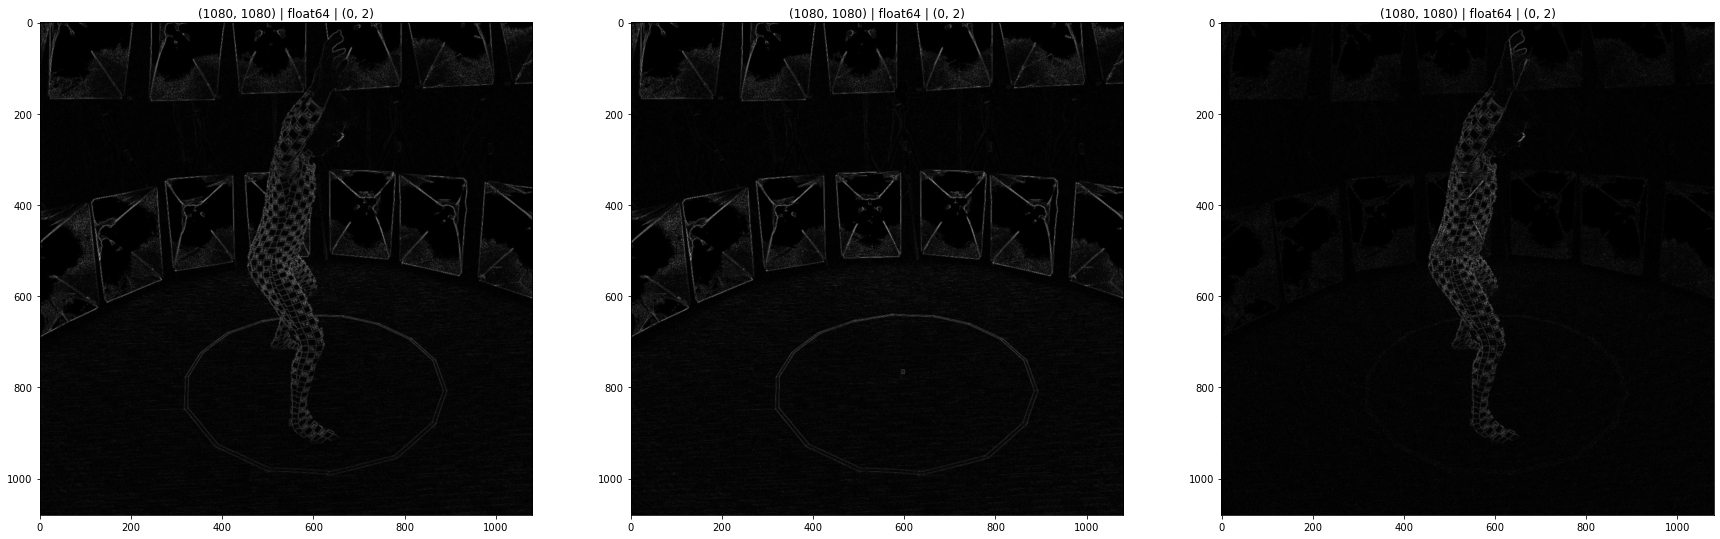

In [116]:
img1_src = (img_refs[img_name][cam_idx]).astype(np.float64)
img2_src = (clean_plates[cam_idx]).astype(np.float64)
# render_row([img1_src, img2_src, np.abs(img1_src-img2_src)])

lap1 = cv2.Laplacian(img1_src, cv2.CV_64F)
lap2 = cv2.Laplacian(img2_src, cv2.CV_64F)
lap1 = np.abs(lap1)
lap2 = np.abs(lap2)
diff = np.abs(lap1-lap2)

render_row([lap1, lap2, ])


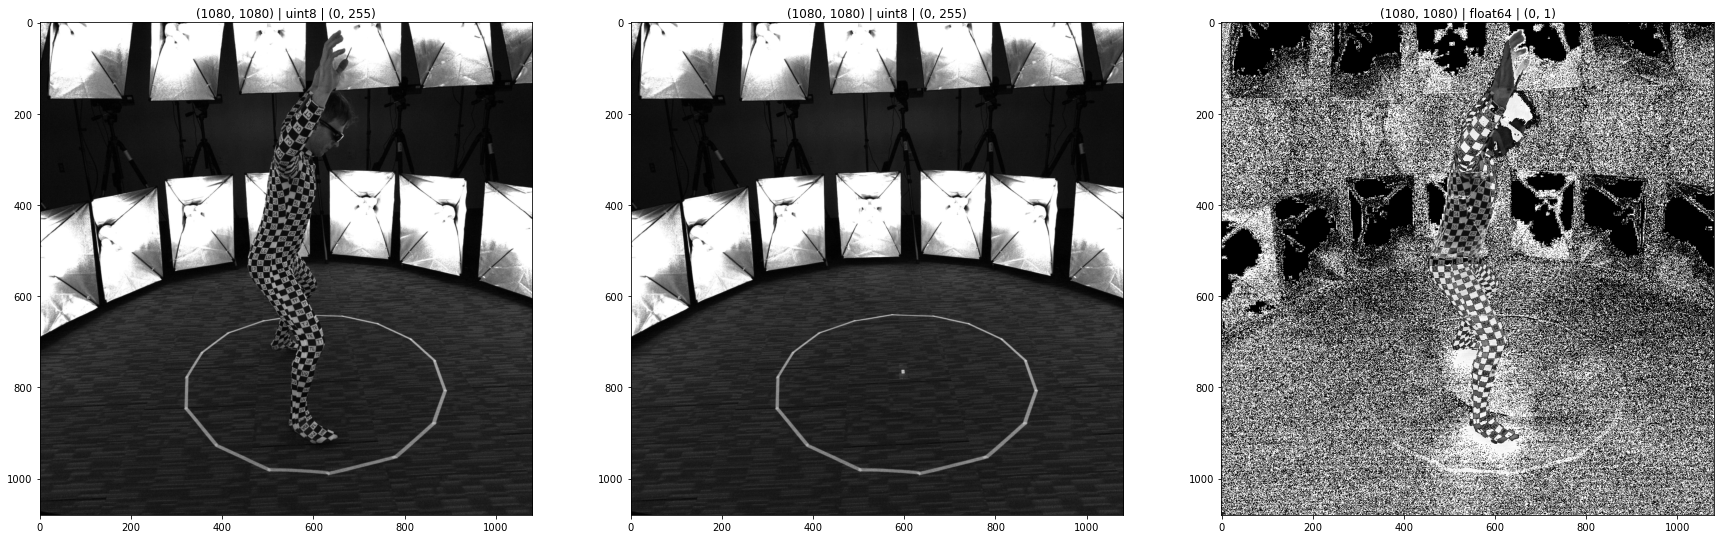

In [56]:
diff = img1_src-img2_src
diff = (diff-np.min(diff))/(np.max(diff)-np.min(diff))
render_row([img1_src, img2_src, diff])
hist1, bins1 = np.histogram(img1_src.ravel(), 256, [0,256])
hist2, bins2 = np.histogram(img2_src.ravel(), 256, [0,256])

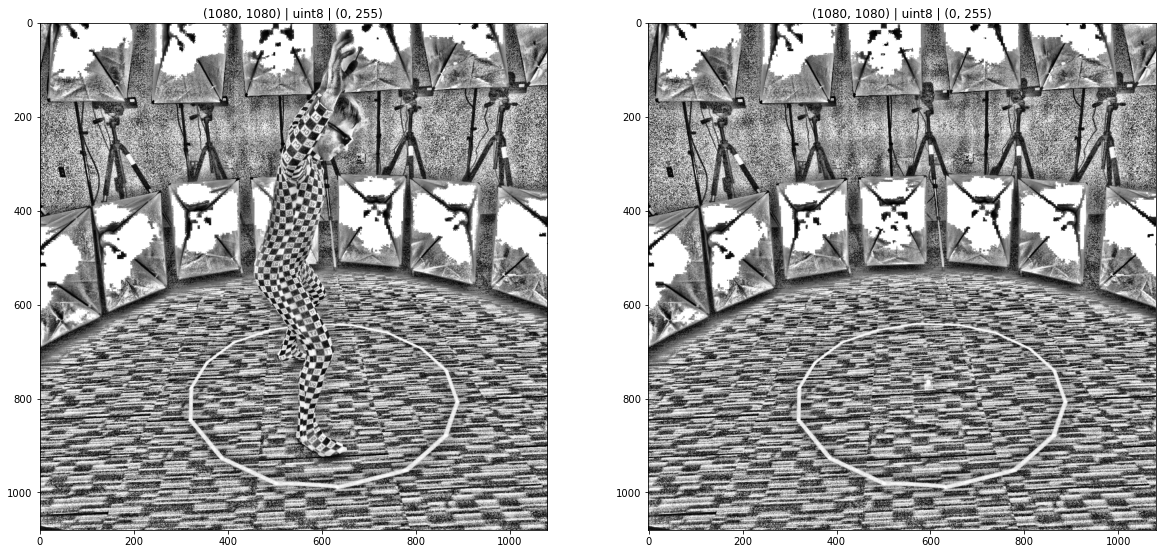

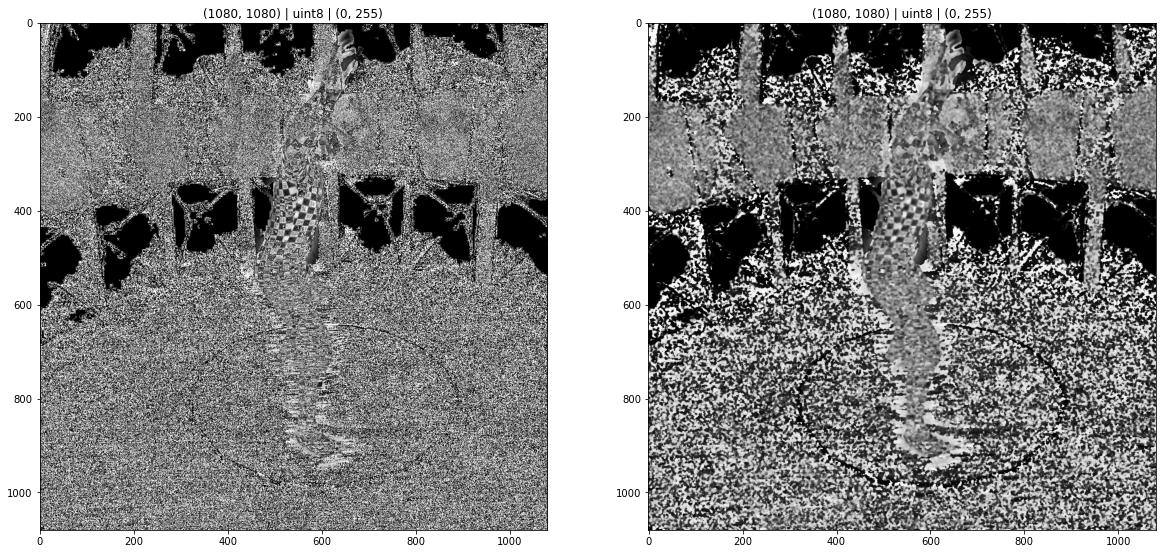

In [75]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank

# Equalization
selem = disk(30)
img1_eq = rank.equalize(img1_src, selem=selem)
img2_eq = rank.equalize(img2_src, selem=selem)

diff = img1_eq - img2_eq
diff_blur = cv2.medianBlur(diff, 5)
render_row([img1_eq, img2_eq])
render_row([diff, diff_blur])

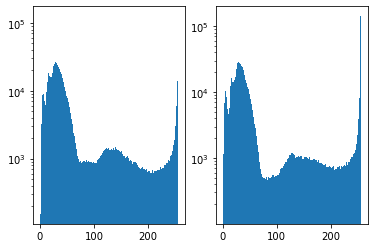

In [69]:
def plot_hist(a, h, b):
    width = 1 * (b[1] - b[0])
    center = (b[:-1] + b[1:]) / 2
    a.bar(center, h, align='center', width=width)
    a.set_yscale('log')
    
fig, ax = plt.subplots(1, 2)
plot_hist(ax[0], hist1, bins1)
plot_hist(ax[1], hist2, bins2)
plt.show()